In [1]:
import math
import multiprocessing
from datetime import datetime
from multiprocessing import freeze_support
from os import walk, path
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from IPython.display import display, HTML
%matplotlib inline

In [2]:
# The day is divided into 3 different classes of light:
# - Daylight
# - Twilight
# - Night
# Since we expect a strong correlation between these values and the light acquired from the 
# light sensor we extract from the timestamp the relative class of the light. The extreme of 
# the intervals are expressed in minutes.

dayframes = {
    (0, 5*60+23): 'NIGHT',
    (5*60+24, 5*60+56): 'TWILIGHT',
    (5*60+57, 20*60+33): 'DAYLIGHT',
    (20*60+34, 21*60+6): 'TWILIGHT',
    (21*60+7, 24*60): 'NIGHT'
}

# Utility dictionary exploited to convert the output of the Google Activity Recognition 
# into a string format

Detected_Activity_List = {
  0.0 : "IN_VEHICLE",
  1.0 : "ON_BICYCLE",
  2.0 : "ON_FOOT",
  3.0 : "STILL",
  4.0 : "UNKNOWN",
  5.0 : "TILTING",
  7.0 : "WALKING",
  8.0 : "RUNNING"
}

# Dictionary that contains a fictitious sensor type for all the non-hardware source of data

sensor_type_dict = {
    'MONITORING':-1,
    'INDOOR':-2,
    'GPS_SATELLITES':-3,
    'GPS_FIX_SATELLITES':-4,
    'GPS_FIX':-5,
    'DETECTED_ACTIVITY':-6,
    'WIFI_ACCESS_POINTS':-7,
    'BLUETOOTH_DEVICES':-8
}

# The final desired order of the columns

ordered_columns = [
    'LUMINOSITY',

    'LUMINOSITY30S',
    'LAST_LUMINOSITY_WHEN_FAR',
    'LAST_LUMINOSITY30S_WHEN_FAR',
    'TIME_FROM_LAST_FAR',

    'WIFI_ACCESS_POINTS',
    'BLUETOOTH_DEVICES',
    'GPS_SATELLITES',
    'GPS_FIX_SATELLITES',
    'GPS_TIME_FROM_FIX',

    'PROXIMITY',
    'DAYLIGHT',
    'TWILIGHT',
    'NIGHT',
    'IN_VEHICLE',
    'ON_BICYCLE',
    'ON_FOOT',
    'STILL',
    'TILTING',
    'WALKING',
    'RUNNING',

    'INDOOR'
]

In [3]:
# This is the main function used in order to preprocess the data, the argument is the name of
# the file that it has to process

def preprocess_data(inputFile):
    print(inputFile)
    df = pd.read_csv(inputFile)
    
    # Sensors accuracy was not consider in this phase of the study
    del df['accuracy']
    
    # Remove duplicate adjacent rows:
    cols = df.columns[1:]
    df = df.loc[(df[cols].shift() != df[cols]).any(axis=1)]
    
    # Since at the end all the dataframe will be merged in a single file, the timestamp is not 
    # a sufficient index( different "sensors" from different phones may have sampled at the 
    # same instant). For this reason a column containing the file name is added and will be 
    #used -with the timestamp- as index.
    df.loc[:,'FileName'] = inputFile
    
    # We assign to each non-hardware source of information a sensor type according to the previously defined dictionary:
    for index,row in df.iterrows():
        if  df.loc[index,'sensor_type'] == -1:
            df.loc[index,'sensor_type'] = sensor_type_dict[ row['sensor_name']]
    
    # In order to create the feature together the feature vectors each time a "sensor" provide
    # a new value we combine it with the last value of each "sensor". In order to keep track of
    # which is the last value for each "sensor" we create the following dictionary:
    last_seen_values = {}
    sensor_types = df['sensor_name'].unique()
    for sensor_type in sensor_types:
        last_seen_values[sensor_type] = float('nan')

    proximity_name = ""
    light_name = ""

    for sensor_type in sensor_types:
        if 'proximity' in sensor_type.lower():
            proximity_name = sensor_type
            continue
        if 'light' in sensor_type.lower():
            light_name = sensor_type
            
    # In order to take into account between the fact that a certain amount of time can elapse
    # from the instant in which a transition indoor-outdoor has occurred and the instant in
    # which the user signal it we drop the value from the light sensor in a 6 seconds windows
    # center at the signaling instant.
    switchlist = []
    for _,row in df.iterrows():
        if row['sensor_name'] == 'INDOOR':
            switchlist.append(row['timestamp'])
    droplist = []
    for index,row in df.iterrows():
        if row['sensor_name'] != light_name:
            continue
        for switch in switchlist:
            if row['timestamp'] > switch - 3*1000 and row['timestamp'] < switch + 3*1000:
                droplist.append(index)
    df.drop(droplist, inplace=True)
    
    df_wide = df.pivot_table(index=['FileName','timestamp'], columns='sensor_name', values='value', aggfunc='first')
    
    last_gps_fix = -1
    last_lum_far = float('nan')
    time_last_far = -1
    is_far = True
    lumfar = {}
    for index,row in df_wide.iterrows():
        
        # If we found a row with "sensor" MONITORING and value 0 it means that the user has 
        # stopped the service, in this case resetting all the last seen value is appropriate in
        # order to avoid to create incorrect feature vector when the user will restart the 
        # monitoring
        if row['MONITORING'] == 0:
            for sensor_type in sensor_types:
                last_seen_values[sensor_type] = float('nan')
            last_gps_fix = -1
            last_lum_far = float('nan')
            time_last_far = -1
            is_far = True
            lumfar = {}
        else:
            # The GPS_FIX column is replaced with the value of the interval of time elapse from
            # the last GPS fix.
            if row['GPS_FIX'] > 0:
                last_gps_fix = index[1]
            if last_gps_fix == -1:
                df_wide.loc[index,'GPS_FIX'] = -1
            else:
                df_wide.loc[index, 'GPS_FIX'] = (index[1] - last_gps_fix)/1000
                
            # Computation of the features related to light and proximity:
            # LAST_LUMINOSITY_WHEN_FAR = last light value obtained when there aren't object 
            #                            that obstructed the light sensor.
            #                            
            # TIME_FROM_LAST_FAR = interval of time elapsed from the last time when there 
            #                      aren't objects that obstructed the device.
            #                       
            # LUMINOSITY30S = average luminosity in the last 30 seconds
            #
            # LAST_LUMINOSITY30S_WHEN_FAR = average of the luminosity in the last 30 seconds 
            #                               when there aren't object that are not obstructing
            #                               the light sensor.
            #                                   
            if not math.isnan(row[proximity_name]):
                is_far = row[proximity_name] > 0.0
            if (not math.isnan(row[light_name])) and is_far:
                last_lum_far = row[light_name]
            if (is_far or time_last_far == -1) and not math.isnan(last_lum_far):
                time_last_far = index[1]
                lumfar[index[1]] = last_lum_far
            if time_last_far == -1:
                time_last_far = index[1]
            df_wide.loc[index, "TIME_FROM_LAST_FAR"] = (index[1] - time_last_far)/1000
            df_wide.loc[index, 'LAST_LUMINOSITY_WHEN_FAR'] = last_lum_far
            lum30s = df[(df['timestamp'] >= (index[1] - 30*1000)) & (df['timestamp'] <= index[1]) & (df['sensor_name'] == light_name)]['value'].mean()
            df_wide.loc[index, 'LUMINOSITY30S'] = lum30s
            lumfar = {k: v for k, v in lumfar.items() if k >= (time_last_far - 30*1000)}
            if len(lumfar.values()) > 0:
                lumsum = 0
                for value in lumfar.values():
                    lumsum += value
                lum30sFar = lumsum/len(lumfar.values())
            else:
                lum30sFar = last_lum_far
            df_wide.loc[index, 'LAST_LUMINOSITY30S_WHEN_FAR'] = lum30sFar
            
            # Updating the last_seen_values for each sensor
            for sensor_type in sensor_types:
                if math.isnan(row[sensor_type]):
                    df_wide.loc[index,sensor_type] = last_seen_values[sensor_type]
                last_seen_values[sensor_type] = row[sensor_type] 

    # Since immediately after the start of a new monitoring session some "sensors" may not have
    # returned a value we add utility column called contains_nan in order to drop the incomplete
    # feature vectors.
    for index,row in df_wide.iterrows():
        containsNaN = 0.0
        for feature in df_wide.columns:
            if feature != 'containsNaN' and math.isnan(row[feature]):
                containsNaN = 1.0
                break
        df_wide.loc[index,'containsNaN'] = containsNaN
    
    df_wide = df_wide[(df_wide['MONITORING'] == 1.0) & (df_wide['containsNaN'] == 0.0) & (df_wide['GPS_FIX'] != -1)] 
    del df_wide['containsNaN']
        
    # Using the day_frames dictionary described above we add a One Hot Encoding relative to the
    # light class to the feature vector. We expect that this value is strongly correlated with
    # the light values collected in the OUTDOOR setting
    for index,row in df_wide.iterrows():
        dt = datetime.fromtimestamp(index[1] / 1000)
        minofday = dt.hour * 60 + dt.minute
        for key in dayframes.keys():
            if minofday < key[1] and minofday > key[0]:
                 df_wide.loc[index, 'TIME_OF_DAY'] = dayframes[key]

    for value in dayframes.values(): 
        df_wide[value] = df_wide['TIME_OF_DAY'] == value  

    del df_wide['TIME_OF_DAY']
    

    # Convert the proximity values -that is vendor dependant but is always characterized by a
    # value equal to 0 and a value greater than 0- into a One Hot Encoding
    df_wide.loc[(df_wide[proximity_name] > 0.0),proximity_name] = 1
    
    # Convert the detected activity from Google Activity Recognition API into a One Hot 
    # Encoding
    for key in Detected_Activity_List.keys(): 
        df_wide[Detected_Activity_List[key]] = df_wide['DETECTED_ACTIVITY'] == key
    
    # Drop useless columns, order the dataframe according to the timestamp and reorder the 
    # column in the desired order
    df_wide.sort_values(['timestamp'], inplace=True)
    del df_wide['MONITORING']
    del df_wide['DETECTED_ACTIVITY']
    del df_wide['UNKNOWN']
    
    cols = [sensor_type for sensor_type in df_wide.columns.to_list() if sensor_type != proximity_name]
    cols.append(proximity_name)
    df_wide = df_wide[cols].replace(True,1.0).replace(False,0.0)
    df_wide.rename(columns={light_name: "LUMINOSITY", proximity_name: "PROXIMITY", 'GPS_FIX': "GPS_TIME_FROM_FIX"}, inplace=True)
    df_wide = df_wide[ordered_columns]
    return df_wide

# Retrieve the filename of all the csv file contained inside the datasets directory
dfs = []
root_directory = "datasets"
_, _, filenames = next(walk(root_directory))
for filename in filenames:
    print(filename)
    if not filename.endswith('.csv'):
        continue
    x = path.join(root_directory,filename)
    dfs.append(preprocess_data(x))
df_wide = pd.concat(dfs)
print(df_wide.describe())

preprocessed_data.csv
datasets\preprocessed_data.csv
sensor_name    LUMINOSITY  LUMINOSITY30S  LAST_LUMINOSITY_WHEN_FAR  \
count        26859.000000   26859.000000              26859.000000   
mean         14211.733199   14171.007104              14238.041066   
std           8318.236013    6939.494329               8277.890025   
min              0.000000       0.000000                  0.000000   
25%           6563.500000    8728.979655               6562.500000   
50%          16776.000000   16899.592357              16777.000000   
75%          19592.000000   18870.122289              19592.000000   
max          65535.000000   29128.254125              65535.000000   

sensor_name  LAST_LUMINOSITY30S_WHEN_FAR  TIME_FROM_LAST_FAR  \
count                       26859.000000        26859.000000   
mean                        14722.567568            2.315000   
std                          6831.623473           15.831461   
min                             3.000000            0.000000

In [4]:
# Drop row from the general dataset in order to have the same number of indoor and outdoor 
# feature vectors
print(df_wide['INDOOR'].value_counts())
df_wide.drop_duplicates(inplace=True)
print(df_wide['INDOOR'].value_counts())
indoor_count = df_wide[df_wide['INDOOR'] == 1.0]['INDOOR'].count()
outdoor_count = df_wide[df_wide['INDOOR'] == 0.0]['INDOOR'].count()
bias = abs(indoor_count - outdoor_count)
print("Bias:", bias)
above = 1.0 if indoor_count > outdoor_count else 0.0

0.0    22560
1.0     4299
Name: INDOOR, dtype: int64
0.0    22560
1.0     4299
Name: INDOOR, dtype: int64
Bias: 18261


In [5]:
if bias > 0:
    sample = df_wide[df_wide['INDOOR'] == above].sample(n=bias)
    df_wide.drop(df_wide[df_wide.index.isin(sample.index)].index, inplace=True)
print(df_wide['INDOOR'].value_counts())

0.0    4299
1.0    4299
Name: INDOOR, dtype: int64


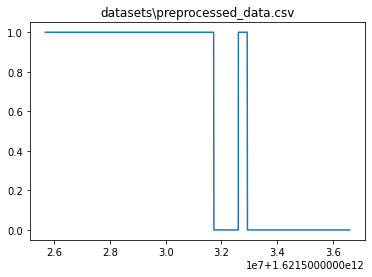

In [6]:
# For debugging purpose plot the indoor/outdoor transitions over time
debug = False
    if debug:
        last_filename = None
        time = []
        indoor = []
        for index, row in df_wide.iterrows():
            filename = index[0]
            if last_filename is None:
                last_filename = filename
            if last_filename != filename:
                plt.plot(time, indoor)
                plt.title(last_filename)
                plt.show()
                plt.close()
                time = []
                indoor = []
                last_filename = filename
            time.append(index[1])
            indoor.append(row['INDOOR'])
        plt.plot(time, indoor)
        plt.title(last_filename)
        plt.show()
        plt.close()

In [7]:
descb = df_wide.describe()
del descb['INDOOR']
descb

sensor_name,LUMINOSITY,LUMINOSITY30S,LAST_LUMINOSITY_WHEN_FAR,LAST_LUMINOSITY30S_WHEN_FAR,TIME_FROM_LAST_FAR,WIFI_ACCESS_POINTS,BLUETOOTH_DEVICES,GPS_SATELLITES,GPS_FIX_SATELLITES,GPS_TIME_FROM_FIX,...,DAYLIGHT,TWILIGHT,NIGHT,IN_VEHICLE,ON_BICYCLE,ON_FOOT,STILL,TILTING,WALKING,RUNNING
count,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,...,8598.000000,8598.000000,8598.0,8598.0,8598.0,8598.000000,8598.000000,8598.000000,8598.0,8598.0
mean,14345.211328,14178.797095,14360.849616,15158.056585,2.747978,3.358921,4.265992,11.476622,5.506629,30.098716,...,0.966969,0.027797,0.0,0.0,0.0,0.173064,0.569784,0.009770,0.0,0.0
std,9259.482211,8054.700956,9237.323574,7973.020155,15.502387,5.193974,4.005764,0.761160,1.922093,17.621175,...,0.178728,0.164401,0.0,0.0,0.0,0.378324,0.495135,0.098364,0.0,0.0
min,0.000000,0.500000,0.000000,10.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
25%,5486.000000,7756.987798,5486.000000,9616.152557,0.000000,0.000000,2.000000,11.000000,4.000000,14.706500,...,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
50%,16457.500000,16925.155606,16457.500000,17209.528798,0.000000,1.000000,3.000000,12.000000,5.000000,30.011000,...,1.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0
75%,20398.750000,19423.147340,20398.750000,20379.923502,0.000000,4.000000,4.000000,12.000000,7.000000,45.157750,...,1.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0
max,65535.000000,28803.016949,65535.000000,27429.043893,203.166000,32.000000,16.000000,13.000000,9.000000,70.052000,...,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0


In [8]:
# Finally we apply the normalize the non-one hot encoded features of each row subtracting 
# the mean and dividing them by the standard deviation. Such value can be obtained with the
# describe function

bypass_norm = ['PROXIMITY', 'DAYLIGHT', 'TWILIGHT', 'NIGHT', 'IN_VEHICLE', 'ON_BICYCLE', 'ON_FOOT', 'STILL', 'TILTING', 'WALKING', 'RUNNING']

for col in df_wide.columns:
    if col == 'INDOOR':
        continue
    if descb.at['max', col] == 0.0:
        descb.at['max', col] = 1.0
    if col in bypass_norm:
        descb.at['mean', col] = 0.0
        descb.at['std', col] = 1.0
        continue
    colMean = descb.at['mean', col]
    colStd = descb.at['std', col]
    if colMean == 0 and colStd == 0:
        descb.at['std', col] = 1.0
        continue
    df_wide[col] = df_wide[col].apply(lambda x: (x - colMean)/colStd)
    

df_wide.to_csv('preprocessed_data.csv')
descb.to_csv('meta.csv')

In [9]:
descb

sensor_name,LUMINOSITY,LUMINOSITY30S,LAST_LUMINOSITY_WHEN_FAR,LAST_LUMINOSITY30S_WHEN_FAR,TIME_FROM_LAST_FAR,WIFI_ACCESS_POINTS,BLUETOOTH_DEVICES,GPS_SATELLITES,GPS_FIX_SATELLITES,GPS_TIME_FROM_FIX,...,DAYLIGHT,TWILIGHT,NIGHT,IN_VEHICLE,ON_BICYCLE,ON_FOOT,STILL,TILTING,WALKING,RUNNING
count,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,8598.000000,...,8598.0,8598.0,8598.0,8598.0,8598.0,8598.0,8598.0,8598.0,8598.0,8598.0
mean,14345.211328,14178.797095,14360.849616,15158.056585,2.747978,3.358921,4.265992,11.476622,5.506629,30.098716,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,9259.482211,8054.700956,9237.323574,7973.020155,15.502387,5.193974,4.005764,0.761160,1.922093,17.621175,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,0.000000,0.500000,0.000000,10.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,5486.000000,7756.987798,5486.000000,9616.152557,0.000000,0.000000,2.000000,11.000000,4.000000,14.706500,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,16457.500000,16925.155606,16457.500000,17209.528798,0.000000,1.000000,3.000000,12.000000,5.000000,30.011000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
75%,20398.750000,19423.147340,20398.750000,20379.923502,0.000000,4.000000,4.000000,12.000000,7.000000,45.157750,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
max,65535.000000,28803.016949,65535.000000,27429.043893,203.166000,32.000000,16.000000,13.000000,9.000000,70.052000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
df_wide

sensor_name                                   LUMINOSITY  LUMINOSITY30S  \
FileName                       timestamp                                  
datasets\preprocessed_data.csv 1621525671899   -1.489415      -1.691534   
                               1621525692081   -1.489415      -1.691534   
                               1621525765578   -1.491035      -1.693396   
                               1621525765625   -1.496867      -1.696748   
                               1621525765681   -1.505291      -1.701093   
...                                                  ...            ...   
                               1621536604498   -1.516630      -1.709066   
                               1621536604600   -1.484555      -1.708929   
                               1621536604647   -1.494599      -1.708874   
                               1621536604704   -1.500755      -1.708853   
                               1621536604967   -1.496543      -1.708349   

sensor_name                                   LAST_LUMINOSITY_WHEN_FAR  \
FileName                       timestamp                                 
datasets\preprocessed_data.csv 1621525671899                 -1.494681   
                               1621525692081                 -1.494681   
                               1621525765578                 -1.496305   
                               1621525765625                 -1.502150   
                               1621525765681                 -1.510594   
...                                                                ...   
                               1621536604498                 -1.521961   
                               1621536604600                 -1.489809   
                               1621536604647                 -1.499877   
                               1621536604704                 -1.506048   
                               1621536604967                 -1.501826   

sensor_name                                   LAST_LUMINOSITY30S_WHEN_FAR  \
FileName                       timestamp                                    
datasets\preprocessed_data.csv 1621525671899                    -1.830609   
                               1621525692081                    -1.831684   
                               1621525765578                    -1.832625   
                               1621525765625                    -1.835196   
                               1621525765681                    -1.838928   
...                                                                   ...   
                               1621536604498                    -1.849356   
                               1621536604600                    -1.849201   
                               1621536604647                    -1.849147   
                               1621536604704                    -1.849128   
                               1621536604967                    -1.848638   

sensor_name                                   TIME_FROM_LAST_FAR  \
FileName                       timestamp                           
datasets\preprocessed_data.csv 1621525671899           -0.177262   
                               1621525692081           -0.177262   
                               1621525765578           -0.177262   
                               1621525765625           -0.177262   
                               1621525765681           -0.177262   
...                                                          ...   
                               1621536604498           -0.177262   
                               1621536604600           -0.177262   
                               1621536604647           -0.177262   
                               1621536604704           -0.177262   
                               1621536604967           -0.177262   

sensor_name                                   WIFI_ACCESS_POINTS  \
FileName                       timestamp                           
datasets\preprocessed_data.csv 1621525